<a href="https://colab.research.google.com/github/Swastick03/ml_lab/blob/main/Fish_Species_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'bengali-fish-images-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4305395%2F7403780%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T071300Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D88589e7ddc3320849583a8858c376ed5d12aef82d7fb0cd241d56907d85242a6adcde345cab47935a1ea72a4b70f49ea9341bba0afd0b86bd403a67967fbf071e0750c558ca02530cdf774cf1e9433ae1f0f52f325bcaf76933421b2882c4c59aff3cf57a0cfcd510938ac4cc173967afcdc3288258347bf07b5cd9254f466795c3b5252b90203eac64952444d53db3731c198dc0b9d71a9c6821ca9dc885bdc870381084a956637eadeab6f057469baff73515c0b15ad1915efe952ca6c5d0563c5c67c3e2f45ffae9bbf304975c256f0029059a51fde9db6d57e355412b1a9136115f224007ea2a0eec3074268c0807e72ebef40fb95f3a683801baf63a246,bengali-fish-market:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4333530%2F7445201%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T071300Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D04e3db8751c81ee416362113df178c6846f3da5354fcdf83bbb3d68c584b73d2873da679987285513d18d32a1990c616d0c514477f92ca3b3895fdf37bb076f896fa020f68d15f0c4fac611fa29007f17676c2f7407996eab5fb0d89b3cdf8efb84f2a0f260030d8dd10ee7f460a9bb19f0c03291dfbce1886223c2c22d9600df295284eba20085ee5e211fda4fce90824036ae7f3f4304a50f5ff7db5533edcdf65576c4c2c384e35d2d7b7f7accca06c5e193b37baa80000338ec7e61eca94b6f5ce08964a3dadb45c28d1afbc92aaf9da53b0ae9a3b3829e6fd8851ebb22c549fb9072f212439cbd8f0a97967e7201c932e717bc5b2987b738899f275c5ec,fish-species-identification-efficientnet:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F4334250%2F7446354%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240912%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240912T071300Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D72cbafd80368780eaac10665721a2d1a8f80b075ba686d822dce387f2c81dbc5db8c57fdcb78a956fe810b58806fbb33e11e7732a1623d7feee064dd786363b9175bb8f7147fcd3727b7a6f02d69985b473915c8117b8143451c6edb1f54d5fa5b411daeb2e1bcc2501b62514b944c22fbea634dad089431c99830c6638820a88b98452e97cf6b55767edf4e655dfdb4e5712a94f888046841126adc2194c3dec6eeec8c8c85b73a340c08d8c3f9da04224617eabbd7335122ccbb2d12f85f4a363c5ed91335cdc4ff006a7c976136248fa3cfe9eee048458400b4bbdc5daa9189eb5b9288b6a308a3cc2d8afacca4f97b6305aaf35f84916b1d9c6cad2ab0ff'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 276279267 bytes downloaded
Downloaded and uncompressed: bengali-fish-images-dataset
[==================================================] 201372686 bytes downloaded
Downloaded and uncompressed: bengali-fish-market
[==================================================] 17459469 bytes downloaded
Downloaded and uncompressed: fish-species-identification-efficientnet
Data source import complete.


In [ ]:
import tensorflow as tf
import numpy as np
from PIL import Image

model = tf.saved_model.load('/kaggle/input/fish-species-identification-efficientnet/EfficientNet')
classes = [ "Ayre" ,  "Catla" ,  "Chital" ,  "Ilish" ,  "Kachki" ,  "Kajoli" ,  "Koi" ,
           "Magur" ,  "Mola Dhela" ,  "Mrigal" ,  "Pabda" ,  "Pangash" ,  "Poa" ,  "Puti" ,
           "Rui" ,  "Shing" ,  "Silver Carp" ,  "Taki" ,  "Telapia" ,  "Tengra" , ]

In [ ]:
Id=[]
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/bengali-fish-market/train'):
    for filename in filenames:
        Id.append(os.path.join(dirname, filename))
Id[:5]

['/kaggle/input/bengali-fish-market/train/Koi/ffb16565-8d9c-4425-8d97-d6a3f2eea65f_a78594bcf4e0488eaf3b4a53bea94e41.jpg',
 '/kaggle/input/bengali-fish-market/train/Koi/efb277e7-21ab-4680-97f3-8e545b3f202f_8ed5327b48ff4a7c8c9d51f60648831d.jpg',
 '/kaggle/input/bengali-fish-market/train/Koi/76ef402b-d3c9-4a55-bbe8-20239cf735a3_37830a31e68447c0a215990dee4f9ee4.jpg',
 '/kaggle/input/bengali-fish-market/train/Koi/22599492-afd6-4986-829d-9c3064ce8ed9_fadd2735aeaa498881c7b7f6086b59a1.jpg',
 '/kaggle/input/bengali-fish-market/train/Koi/a3cf0d70-0239-4e16-97db-37503d970516_d541fbe9334a493388efa4ade4abfcd4.jpg']

In [ ]:
train=pd.DataFrame()
train=train.assign(filename=Id)
train.head()

,filename
0,/kaggle/input/bengali-fish-market/train/Koi/ff...
1,/kaggle/input/bengali-fish-market/train/Koi/ef...
2,/kaggle/input/bengali-fish-market/train/Koi/76...
3,/kaggle/input/bengali-fish-market/train/Koi/22...
4,/kaggle/input/bengali-fish-market/train/Koi/a3...


In [ ]:
train['label']=train['filename']
train['label']=train['label'].str.replace('/kaggle/input/bengali-fish-market/train/','')
train.head()

,filename,label
0,/kaggle/input/bengali-fish-market/train/Koi/ff...,Koi/ffb16565-8d9c-4425-8d97-d6a3f2eea65f_a7859...
1,/kaggle/input/bengali-fish-market/train/Koi/ef...,Koi/efb277e7-21ab-4680-97f3-8e545b3f202f_8ed53...
2,/kaggle/input/bengali-fish-market/train/Koi/76...,Koi/76ef402b-d3c9-4a55-bbe8-20239cf735a3_37830...
3,/kaggle/input/bengali-fish-market/train/Koi/22...,Koi/22599492-afd6-4986-829d-9c3064ce8ed9_fadd2...
4,/kaggle/input/bengali-fish-market/train/Koi/a3...,Koi/a3cf0d70-0239-4e16-97db-37503d970516_d541f...


In [ ]:
train['label'] = train['label'].str.split('/').str[0]
train.head()

,filename,label
0,/kaggle/input/bengali-fish-market/train/Koi/ff...,Koi
1,/kaggle/input/bengali-fish-market/train/Koi/ef...,Koi
2,/kaggle/input/bengali-fish-market/train/Koi/76...,Koi
3,/kaggle/input/bengali-fish-market/train/Koi/22...,Koi
4,/kaggle/input/bengali-fish-market/train/Koi/a3...,Koi


In [ ]:
Id=[]
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/bengali-fish-market/test'):
    for filename in filenames:
        Id.append(os.path.join(dirname, filename))
Id[:5]

['/kaggle/input/bengali-fish-market/test/Koi/f8ad3fee-c8b9-4fb7-bd67-ed7481148062_bcbbfc668573447f91b2cef844418cfe.jpg',
 '/kaggle/input/bengali-fish-market/test/Koi/37796b01-81b6-466b-9fef-fca99c68410c_f9ba6ee54520409e8f2902bc204d5050.jpg',
 '/kaggle/input/bengali-fish-market/test/Koi/3cf1c7cf-e912-4200-9f62-fbe86ece8f3f_aa5dc1d58dac420ea6f8df968b86d77d.jpg',
 '/kaggle/input/bengali-fish-market/test/Koi/e4cb8cb7-31a9-404b-9de5-9cb95609ab85_a5366ace29804bb1b957efb174834bee.jpg',
 '/kaggle/input/bengali-fish-market/test/Koi/4d1108f9-b8f2-480e-ab74-66f43762ef07_02fdf09b70cb4660ad710a3eeab38439.jpg']

In [ ]:
test=pd.DataFrame()
test=test.assign(filename=Id)
test.head()

,filename
0,/kaggle/input/bengali-fish-market/test/Koi/f8a...
1,/kaggle/input/bengali-fish-market/test/Koi/377...
2,/kaggle/input/bengali-fish-market/test/Koi/3cf...
3,/kaggle/input/bengali-fish-market/test/Koi/e4c...
4,/kaggle/input/bengali-fish-market/test/Koi/4d1...


In [ ]:
test['label']=test['filename']
test['label']=test['label'].str.replace('/kaggle/input/bengali-fish-market/test/','')
test.head()

,filename,label
0,/kaggle/input/bengali-fish-market/test/Koi/f8a...,Koi/f8ad3fee-c8b9-4fb7-bd67-ed7481148062_bcbbf...
1,/kaggle/input/bengali-fish-market/test/Koi/377...,Koi/37796b01-81b6-466b-9fef-fca99c68410c_f9ba6...
2,/kaggle/input/bengali-fish-market/test/Koi/3cf...,Koi/3cf1c7cf-e912-4200-9f62-fbe86ece8f3f_aa5dc...
3,/kaggle/input/bengali-fish-market/test/Koi/e4c...,Koi/e4cb8cb7-31a9-404b-9de5-9cb95609ab85_a5366...
4,/kaggle/input/bengali-fish-market/test/Koi/4d1...,Koi/4d1108f9-b8f2-480e-ab74-66f43762ef07_02fdf...


In [ ]:
test['label'] = test['label'].str.split('/').str[0]
test.head()

,filename,label
0,/kaggle/input/bengali-fish-market/test/Koi/f8a...,Koi
1,/kaggle/input/bengali-fish-market/test/Koi/377...,Koi
2,/kaggle/input/bengali-fish-market/test/Koi/3cf...,Koi
3,/kaggle/input/bengali-fish-market/test/Koi/e4c...,Koi
4,/kaggle/input/bengali-fish-market/test/Koi/4d1...,Koi


In [ ]:
result=[]
for i in test.filename:
    img = Image.open(i).convert('RGB')
    img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)
    inp_numpy = np.array(img)[None]
    inp = tf.constant(inp_numpy, dtype='float32')
    class_scores = model(inp)[0].numpy()
    result.append(classes[class_scores.argmax()])
result[:5]

<ipython-input-11-d4a838ea7fd1>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)


['Koi', 'Koi', 'Koi', 'Koi', 'Koi']

In [ ]:
test=test.assign(prediction=result)
test.head()

,filename,label,prediction
0,/kaggle/input/bengali-fish-market/test/Koi/f8a...,Koi,Koi
1,/kaggle/input/bengali-fish-market/test/Koi/377...,Koi,Koi
2,/kaggle/input/bengali-fish-market/test/Koi/3cf...,Koi,Koi
3,/kaggle/input/bengali-fish-market/test/Koi/e4c...,Koi,Koi
4,/kaggle/input/bengali-fish-market/test/Koi/4d1...,Koi,Koi


In [ ]:
result=[]
for i in train.filename:
    img = Image.open(i).convert('RGB')
    img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)
    inp_numpy = np.array(img)[None]
    inp = tf.constant(inp_numpy, dtype='float32')
    class_scores = model(inp)[0].numpy()
    result.append(classes[class_scores.argmax()])
result[:5]

<ipython-input-13-f4d30955072f>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)


['Koi', 'Koi', 'Koi', 'Koi', 'Koi']

In [ ]:
train=train.assign(prediction=result)
train.head()

,filename,label,prediction
0,/kaggle/input/bengali-fish-market/train/Koi/ff...,Koi,Koi
1,/kaggle/input/bengali-fish-market/train/Koi/ef...,Koi,Koi
2,/kaggle/input/bengali-fish-market/train/Koi/76...,Koi,Koi
3,/kaggle/input/bengali-fish-market/train/Koi/22...,Koi,Koi
4,/kaggle/input/bengali-fish-market/train/Koi/a3...,Koi,Koi


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(train['label'],train['prediction']))

              precision    recall  f1-score   support

        Ayre       0.91      0.98      0.94        87
       Catla       0.96      0.97      0.97       102
      Chital       0.99      0.97      0.98       142
       Ilish       0.86      1.00      0.92        55
      Kachki       0.97      0.91      0.94        33
      Kajoli       0.91      0.91      0.91        34
         Koi       0.97      0.93      0.95        97
       Magur       0.97      0.99      0.98       110
  Mola Dhela       0.95      0.93      0.94        41
      Mrigal       0.83      0.91      0.86        53
       Pabda       0.94      0.93      0.93        94
     Pangash       1.00      0.93      0.96        94
         Poa       1.00      0.91      0.96        35
        Puti       0.93      0.95      0.94        97
         Rui       0.94      0.89      0.91       114
       Shing       0.96      0.95      0.96       102
 Silver Carp       0.98      0.93      0.96       106
        Taki       0.90    

In [ ]:
print(classification_report(test['label'],test['prediction']))

              precision    recall  f1-score   support

        Ayre       0.74      0.77      0.76        22
       Catla       0.78      0.81      0.79        26
      Chital       0.97      0.86      0.91        35
       Ilish       0.70      1.00      0.82        14
      Kachki       0.71      0.62      0.67         8
      Kajoli       0.50      0.38      0.43         8
         Koi       0.81      0.84      0.82        25
       Magur       0.89      0.89      0.89        28
  Mola Dhela       0.71      0.45      0.56        11
      Mrigal       0.54      0.50      0.52        14
       Pabda       0.72      0.78      0.75        23
     Pangash       1.00      0.83      0.91        24
         Poa       0.43      0.38      0.40         8
        Puti       0.67      0.75      0.71        24
         Rui       0.63      0.70      0.67        27
       Shing       0.77      0.88      0.82        26
 Silver Carp       0.91      0.77      0.83        26
        Taki       0.78    

In [ ]:
Id=[]
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input/bengali-fish-market/sol'):
    for filename in filenames:
        Id.append(os.path.join(dirname, filename))
Id[:5]

['/kaggle/input/bengali-fish-market/sol/unknown_05_890fa9117fd6498c848a344de0d73a8c.jpg',
 '/kaggle/input/bengali-fish-market/sol/unknown_07_0578b00198b6428f8463e87a060973b4.jpg',
 '/kaggle/input/bengali-fish-market/sol/unknown_03_c977474c60c64d57b91f3921722fe398.jpg',
 '/kaggle/input/bengali-fish-market/sol/unknown_16_be02e800ea594358b61464421750555c.png',
 '/kaggle/input/bengali-fish-market/sol/unknown_10_fde3b184abd44d5ea8de0d33d74d55ba.jpg']

In [ ]:
sol=pd.DataFrame()
sol=sol.assign(filename=Id)
sol.head()

,filename
0,/kaggle/input/bengali-fish-market/sol/unknown_...
1,/kaggle/input/bengali-fish-market/sol/unknown_...
2,/kaggle/input/bengali-fish-market/sol/unknown_...
3,/kaggle/input/bengali-fish-market/sol/unknown_...
4,/kaggle/input/bengali-fish-market/sol/unknown_...


In [ ]:
result=[]
for i in sol.filename:
    img = Image.open(i).convert('RGB')
    img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)
    inp_numpy = np.array(img)[None]
    inp = tf.constant(inp_numpy, dtype='float32')
    class_scores = model(inp)[0].numpy()
    result.append(classes[class_scores.argmax()])
result[:5]

<ipython-input-20-19b6426b20e6>:4: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)


['Shing', 'Poa', 'Tengra', 'Ayre', 'Taki']

In [ ]:
sol=sol.assign(prediction=result)
sol=sol[['prediction']]
sol.head()

,prediction
0,Shing
1,Poa
2,Tengra
3,Ayre
4,Taki


In [ ]:
sol.to_csv('./EfficientNet.csv',index=False)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


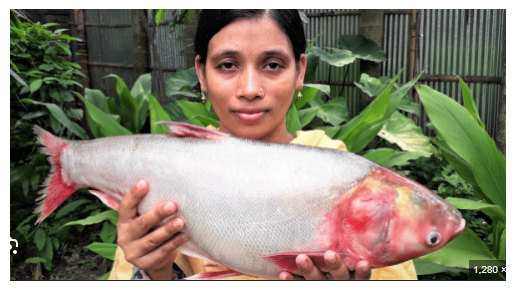

<ipython-input-24-39e40ac4b244>:14: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)


Predicted Class: Silver Carp


In [ ]:
import matplotlib.pyplot as plt


# Load and process your image
image_path = "/content/drive/MyDrive/fish.png"
img = Image.open(image_path).convert('RGB')

# Display the image
plt.imshow(img)
plt.axis('off')  # Hide axes for better visualization
plt.show()

# Resize the image for model input
img = img.resize((300, 300 * img.size[1] // img.size[0]), Image.ANTIALIAS)
inp_numpy = np.array(img)[None]  # Add batch dimension
inp = tf.constant(inp_numpy, dtype='float32')

# Make predictions with the model
class_scores = model(inp)[0].numpy()

# Get the predicted class
predicted_class = classes[class_scores.argmax()]
print(f"Predicted Class: {predicted_class}")
